In [8]:
import pandas as pd
import librosa
import os
import numpy as np
metadata = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')

metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [10]:
print(metadata["class"].value_counts())
class_names = [ 'dog_bark', 
        'children_playing', 
        'air_conditioner', 
        'street_music', 
        'jackhammer', 
        'engine_idling', 
        'drilling', 
        'siren', 
        'car_horn', 
        'gun_shot']

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [14]:
import matplotlib.pyplot as plt
from IPython.display import Audio
audio_file_path = "/kaggle/input/urbansound8k/fold10/100648-1-0-0.wav"
audio_data, sample_rate = librosa.load(audio_file_path, sr=None)

Audio(audio_file_path)

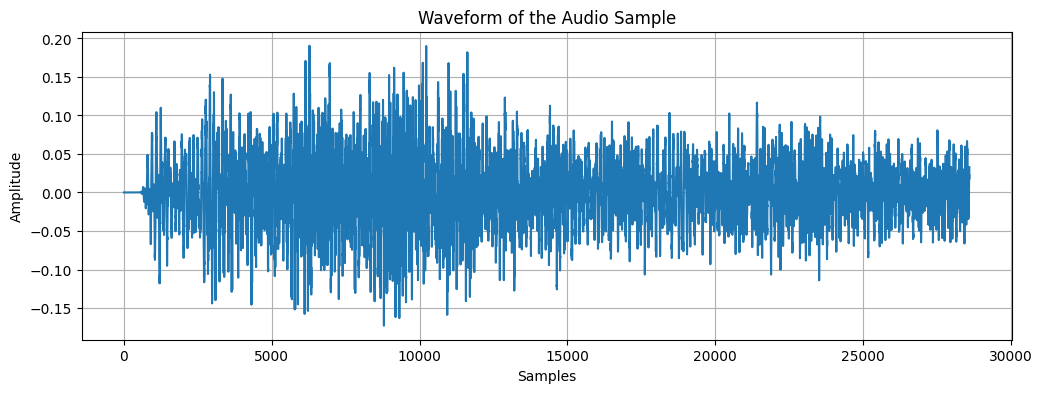

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title('Waveform of the Audio Sample')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [16]:
import os
import numpy as np
import pandas as pd
import librosa
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(file_path, sample_rate):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

def load_audio_files(dataframe, sample_rate=22050, duration=5):
    audio_data = []
    labels = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for index, row in dataframe.iterrows():
            file_path = os.path.join('/kaggle/input/urbansound8k', 'fold' + str(row['fold']), row['slice_file_name'])
            futures.append(executor.submit(process_audio_file, file_path, sample_rate))
            labels.append(row['classID'])

        for future in futures:
            audio_data.append(future.result())

    return np.array(audio_data), np.array(labels)


X, y = load_audio_files(metadata)
print(X.shape, y.shape)

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


(8732, 13) (8732,)


In [17]:
print(y[1])#labels
print(X[1])#Audio Data

2
[-417.00525     99.336624   -42.995586    51.073326     9.853778
    7.9696927   11.197088     1.9291176    7.0303974    4.270228
   -3.5847254   13.890946    -2.7644932]


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (X_train.shape[1], X_train.shape[2])  
model = models.Sequential([
    layers.GRU(64, input_shape=input_shape, return_sequences=True),
    layers.GRU(32),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
    
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2564 - loss: 2.0846 - val_accuracy: 0.4889 - val_loss: 1.4699
Epoch 2/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5361 - loss: 1.4247 - val_accuracy: 0.5576 - val_loss: 1.3528
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5929 - loss: 1.2102 - val_accuracy: 0.5727 - val_loss: 1.2755
Epoch 4/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6240 - loss: 1.1353 - val_accuracy: 0.6228 - val_loss: 1.1557
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6550 - loss: 1.0167 - val_accuracy: 0.6192 - val_loss: 1.1603
Epoch 6/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6911 - loss: 0.9604 - val_accuracy: 0.6528 - val_loss: 1.0299
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7095 - loss: 0.8830 - val_accuracy: 0.6514 - val_loss: 1.0328
Epoch 8/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7117 - loss: 0.8581 - val_accuracy: 0.

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7403 - loss: 0.9158
Test Accuracy: 0.7532913684844971


In [22]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = y_test
report = classification_report(actual_classes, predicted_classes, target_names= [ 'dog_bark', 
        'children_playing', 
        'air_conditioner', 
        'street_music', 
        'jackhammer', 
        'engine_idling', 
        'drilling', 
        'siren', 
        'car_horn', 
        'gun_shot'])

print(report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                  precision    recall  f1-score   support

        dog_bark       0.73      0.90      0.80       203
children_playing       0.67      0.63      0.65        86
 air_conditioner       0.63      0.69      0.66       183
    street_music       0.73      0.64      0.68       201
      jackhammer       0.83      0.71      0.76       206
   engine_idling       0.83      0.88      0.86       193
        drilling       0.69      0.78      0.73        72
           siren       0.89      0.87      0.88       208
        car_horn       0.70      0.93      0.80       165
        gun_shot       0.77      0.51      0.61       230

        accuracy                           0.75      1747
       macro avg       0.75      0.75      0.74      1747
    weighted avg       0.76      0.75      0.75      1747



In [23]:
predictions = model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)

actual_classes = y_test

for i in range(10):  
    print(f'Predicted: {predicted_classes[i]}, Actual: {actual_classes[i]}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted: 7, Actual: 8
Predicted: 9, Actual: 9
Predicted: 4, Actual: 4
Predicted: 8, Actual: 8
Predicted: 9, Actual: 3
Predicted: 7, Actual: 7
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 4, Actual: 4
Predicted: 3, Actual: 3


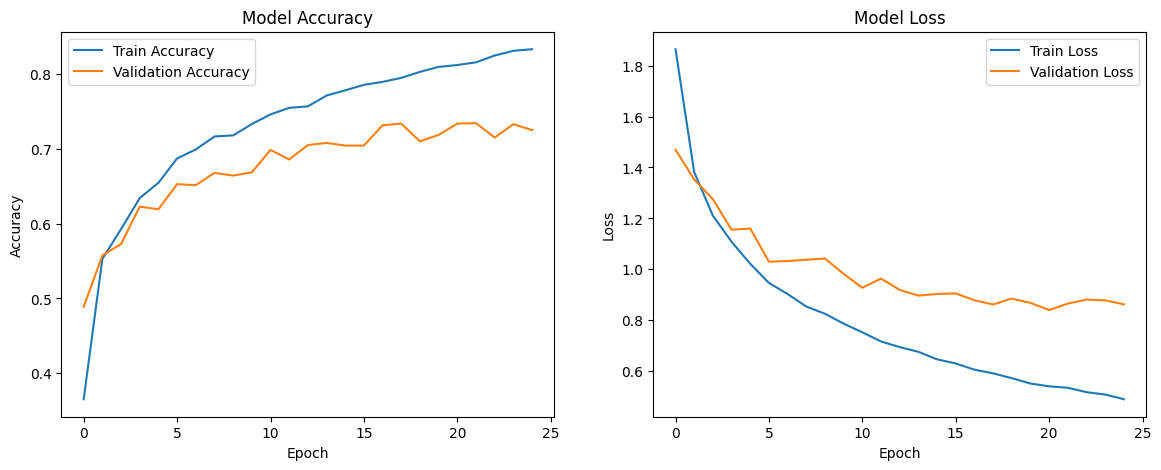

In [24]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

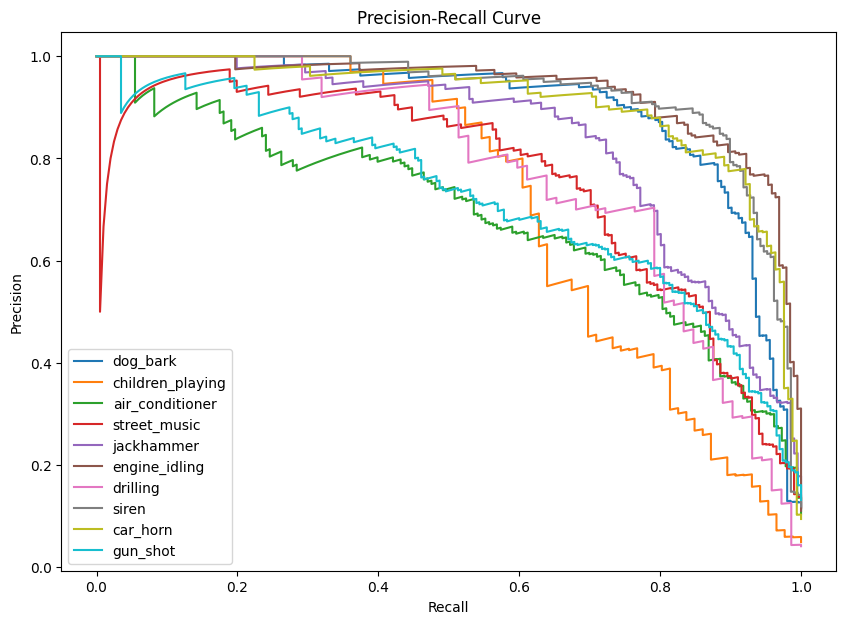

In [25]:
from sklearn.metrics import precision_recall_curve

precision = {}
recall = {}
thresholds = {}

for i, class_name in enumerate(class_names):  
    precision[i], recall[i], thresholds[i] = precision_recall_curve((actual_classes == i).astype(int), predictions[:, i])

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(class_names):
    plt.plot(recall[i], precision[i], label=class_name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

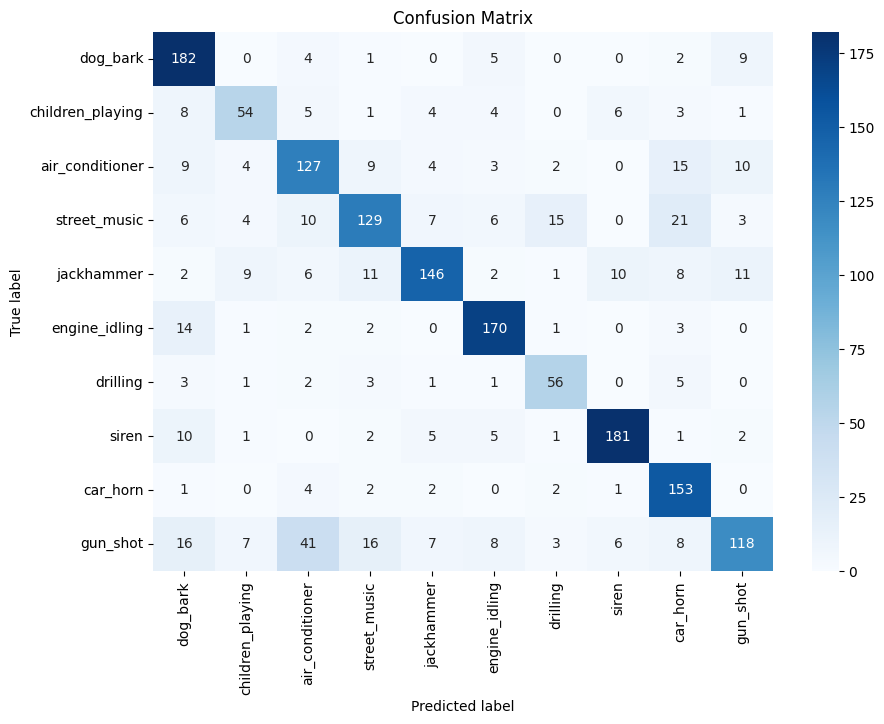

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_labels = y_test  


cm = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names), 
            yticklabels=list(class_names ))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

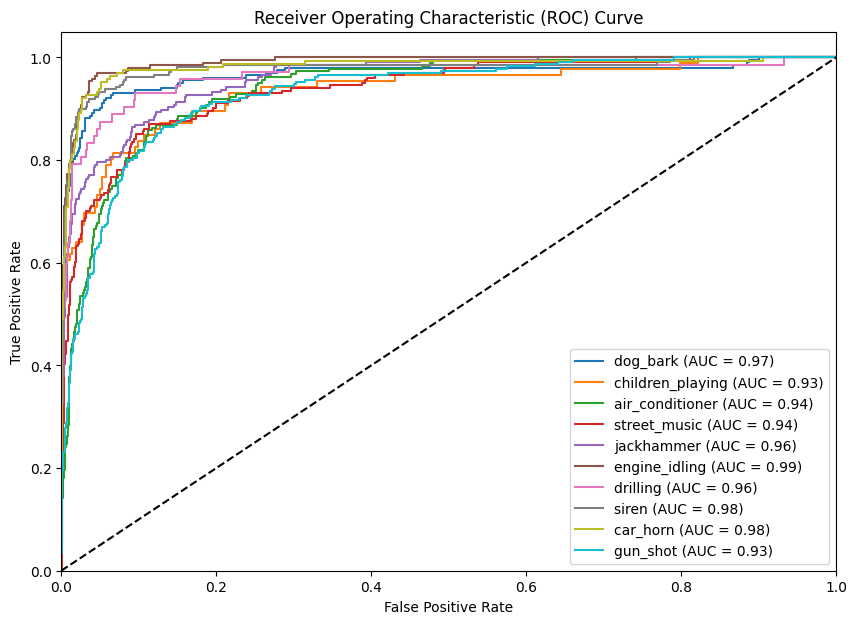

In [27]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}

for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve((actual_classes == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()